# Data Analysis for Litter Index and Crime Incidents

- **Research Question:** What is the correlation between crime rates and litter index in Philadelphia?

- **Hypothesis:** An area’s litter index is likely higher if the location has a higher crime density.

- In this notebook, we will analyze the relationship between Philadelphia's crime density through number of incidents and litter index.

## Set up

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import warnings
warnings.simplefilter('ignore')

## Opening Litter Index and Cleaning Up Data

In [3]:
litter_index = pd.read_csv('../data/litter_index.csv')
litter_index

,OBJECTID,SEG_ID,HUNDRED_BLOCK_SCORE,LR_HUNDRED_BLOCK,YEAR,STREET_CLASS,STREET_CLASS_NAME,SCORE_COLOR,Shape__Length
0,1,521289,2.000000,1900 INGERSOLL ST,2018,5,Local,YELLOW,353.430892
1,2,521255,2.000000,1800 MASTER ST,2018,4,Collector,YELLOW,449.994425
2,3,420128,1.333333,1800 W STILES ST,2018,5,Local,GREEN,137.701612
3,4,420127,2.000000,1200 N 18TH ST,2018,4,Collector,YELLOW,142.859613
4,5,421610,2.000000,1200 N 20TH ST,2018,4,Collector,YELLOW,183.767439
...,...,...,...,...,...,...,...,...,...
79598,79599,600718,1.333333,0 LEVERINGTON AVE,2017,5,Local,GREEN,115.132244
79599,79600,543785,0.000000,1700 N DELAWARE AVE,2017,3,Minor Arterial,GREY,195.655423
79600,79601,1080636,1.333333,12600 NANTON DR,2017,4,Collector,GREEN,140.685545
79601,79602,880684,1.333333,4800 GRANT AVE,2017,2,Major Arterial,GREEN,159.615075


In [4]:
# Remove unnecessary columns and keep the ones we need
copy0_df = ['HUNDRED_BLOCK_SCORE', 'LR_HUNDRED_BLOCK', 'YEAR', 'STREET_CLASS', 'STREET_CLASS_NAME', 'SCORE_COLOR']
litter_index= litter_index[copy0_df].copy()
litter_index

,HUNDRED_BLOCK_SCORE,LR_HUNDRED_BLOCK,YEAR,STREET_CLASS,STREET_CLASS_NAME,SCORE_COLOR
0,2.000000,1900 INGERSOLL ST,2018,5,Local,YELLOW
1,2.000000,1800 MASTER ST,2018,4,Collector,YELLOW
2,1.333333,1800 W STILES ST,2018,5,Local,GREEN
3,2.000000,1200 N 18TH ST,2018,4,Collector,YELLOW
4,2.000000,1200 N 20TH ST,2018,4,Collector,YELLOW
...,...,...,...,...,...,...
79598,1.333333,0 LEVERINGTON AVE,2017,5,Local,GREEN
79599,0.000000,1700 N DELAWARE AVE,2017,3,Minor Arterial,GREY
79600,1.333333,12600 NANTON DR,2017,4,Collector,GREEN
79601,1.333333,4800 GRANT AVE,2017,2,Major Arterial,GREEN


In [5]:
sorted_highest_litter = litter_index.sort_values(by='HUNDRED_BLOCK_SCORE', ascending=False)
sorted_highest_litter.head(10)

,HUNDRED_BLOCK_SCORE,LR_HUNDRED_BLOCK,YEAR,STREET_CLASS,STREET_CLASS_NAME,SCORE_COLOR
3844,4.0,0/400 W ROOSEVELT BLVD,2018,2,Major Arterial,MAROON
70972,4.0,4500 N 9TH ST,2017,3,Minor Arterial,MAROON
10284,4.0,1000 W ORLEANS ST,2018,5,Local,MAROON
29785,4.0,3700 FAIRMOUNT AVE,2018,4,Collector,MAROON
29786,4.0,600 N 36TH ST,2018,4,Collector,MAROON
70967,4.0,4400 N 9TH ST,2017,3,Minor Arterial,MAROON
77974,4.0,4400 CASTOR AVE,2017,2,Major Arterial,MAROON
10282,4.0,2900 N 11TH ST,2018,4,Collector,MAROON
10281,4.0,2900 N 11TH ST,2018,4,Collector,MAROON
10280,4.0,2900 N 11TH ST,2018,4,Collector,MAROON


In [6]:
sorted_lowest_litter = litter_index.sort_values(by='HUNDRED_BLOCK_SCORE', ascending=True)
sorted_lowest_litter.head(10)

,HUNDRED_BLOCK_SCORE,LR_HUNDRED_BLOCK,YEAR,STREET_CLASS,STREET_CLASS_NAME,SCORE_COLOR
71065,0.0,1700 N DELAWARE AVE,2017,3,Minor Arterial,GREY
74708,0.0,0 BROOKSHIRE DR,2017,5,Local,GREY
74709,0.0,0 BROOKSHIRE LN,2017,5,Local,GREY
74710,0.0,0 BROOKSHIRE DR,2017,5,Local,GREY
61996,0.0,0 RED LION RD,2017,3,Minor Arterial,GREY
61997,0.0,0 RED LION RD,2017,3,Minor Arterial,GREY
74711,0.0,0 BROOKSHIRE CT,2017,5,Local,GREY
74712,0.0,0 BROOKSHIRE DR,2017,5,Local,GREY
74713,0.0,0 BROOKSHIRE DR,2017,5,Local,GREY
74714,0.0,0 BROOKSHIRE PL,2017,5,Local,GREY


We can see here that lower the 'HUNDRED_BLOCK_SCORE', the cleaner the street as it indicates less litter by 'SCORE_COLOR'. In addition, we can see places with highest litter index (4.0) and lowest litter index (0).

As there are 158 different neighborhoods and the litter index is not mapped to neighborhoods specifically, we will use the neighborhoods to see which neighborhood areas of Philadelphia using longitude and latitude are more affected.

## Opening Crime Incidents in 2017 and 2018, Cleaning, and Merging Them

Since the Litter Index data is from 2017 and 2018, we only need to consider data points for crime from 2017 and 2018.

In [5]:
# Mergiing 2017 and 2018 crime dataset
crime_2017 = pd.read_csv('../data/crime_2017.csv')
crime_2018 = pd.read_csv('../data/crime_2018.csv')
crime_2017_18 = pd.concat([crime_2017, crime_2018], ignore_index=True)
crime_2017_18

,objectid,dc_dist,psa,dispatch_date_time,dispatch_date,dispatch_time,hour,dc_key,location_block,ucr_general,text_general_code,point_x,point_y,lat,lng
0,285,25,4,2017-06-15 12:02:00+00,2017-06-15,08:02:00,8.0,2.017250e+11,N 13TH ST / W SOMERSET ST,300,Robbery No Firearm,-75.152044,39.995251,39.995251,-75.152044
1,289,12,3,2017-05-08 02:02:00+00,2017-05-07,22:02:00,22.0,2.017120e+11,6500 BLOCK ELMWOOD AVE,400,Aggravated Assault Firearm,-75.230330,39.922211,39.922211,-75.230330
2,294,19,1,2017-04-08 20:04:00+00,2017-04-08,16:04:00,16.0,2.017190e+11,400 BLOCK N SIMPSON ST,600,Theft from Vehicle,-75.248510,39.969223,39.969223,-75.248510
3,295,9,3,2017-06-06 12:16:00+00,2017-06-06,08:16:00,8.0,2.017090e+11,2800 BLOCK PENNSYLVANIA AV,600,Theft from Vehicle,-75.182789,39.970152,39.970152,-75.182789
4,308,25,4,2017-09-11 15:16:00+00,2017-09-11,11:16:00,11.0,2.017251e+11,2900 BLOCK N REESE ST,600,Thefts,-75.140193,39.995260,39.995260,-75.140193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313560,11085790,15,1,2018-09-17 04:00:00+00,2018-09-17,00:00:00,18.0,2.018151e+11,5000 BLOCK HAWTHORNE ST,100,Homicide - Criminal,-75.076444,40.018905,40.018905,-75.076444
313561,11085791,16,2,2018-09-28 04:00:00+00,2018-09-28,00:00:00,21.0,2.018160e+11,5100 BLOCK HAVERFORD AV,100,Homicide - Criminal,-75.222678,39.964357,39.964357,-75.222678
313562,11085792,16,2,2018-09-29 04:00:00+00,2018-09-29,00:00:00,21.0,2.018160e+11,5100 BLOCK HAVERFORD AV,100,Homicide - Criminal,-75.222678,39.964357,39.964357,-75.222678
313563,11085795,18,2,2018-11-29 05:00:00+00,2018-11-29,00:00:00,14.0,2.018181e+11,5400 BLOCK CEDAR AVE,100,Homicide - Criminal,-75.232255,39.951199,39.951199,-75.232255


In [6]:
# Remove unnecessary columns and keep the ones we need
copy1_df = ['text_general_code', 'point_x', 'point_y', 'lat', 'lng']
crime_2017_18 = crime_2017_18[copy1_df].copy()
crime_2017_18

,text_general_code,point_x,point_y,lat,lng
0,Robbery No Firearm,-75.152044,39.995251,39.995251,-75.152044
1,Aggravated Assault Firearm,-75.230330,39.922211,39.922211,-75.230330
2,Theft from Vehicle,-75.248510,39.969223,39.969223,-75.248510
3,Theft from Vehicle,-75.182789,39.970152,39.970152,-75.182789
4,Thefts,-75.140193,39.995260,39.995260,-75.140193
...,...,...,...,...,...
313560,Homicide - Criminal,-75.076444,40.018905,40.018905,-75.076444
313561,Homicide - Criminal,-75.222678,39.964357,39.964357,-75.222678
313562,Homicide - Criminal,-75.222678,39.964357,39.964357,-75.222678
313563,Homicide - Criminal,-75.232255,39.951199,39.951199,-75.232255


## Opening Litter Index and Neighborhood geoJson

In [7]:
litter_gdf = gpd.read_file('../data/litter_index.geojson')

In [8]:
neighborhood = gpd.read_file('../data/Neighborhoods_Philadelphia.geojson')

## Creating GeoDataFrame from the Crime Data

In [9]:
# Dropping rows with missing or invalid coordinates
crime_df = crime_2017_18.dropna(subset=['lat', 'lng'])

In [10]:
# Creating GeoDataFrame
geometry_crime = [Point(xy) for xy in zip(crime_df['lng'], crime_df['lat'])]
crime_gdf = gpd.GeoDataFrame(crime_df, geometry=geometry_crime, crs='EPSG:4326')

## Plotting Litter Index and Crime Density in Philadelphia by Neighborhood

In [11]:
# Checking and match CRS to make sure the mapping is the same
if crime_gdf.crs != litter_gdf.crs:
    crime_gdf = crime_gdf.to_crs(litter_gdf.crs)

# Spatial join between crime and neighborhood GeoDataFrames
crime_by_neighborhood = gpd.sjoin(crime_gdf, neighborhood, how='left', op='within')

# Aggregate crime data by neighborhood
crime_counts = crime_by_neighborhood.groupby('index_right').size().reset_index(name='crime_count')

# Merging crime data with neighborhood geometries
neighborhood_crime_gdf = neighborhood.merge(crime_counts, left_index=True, right_on='index_right', how='left')

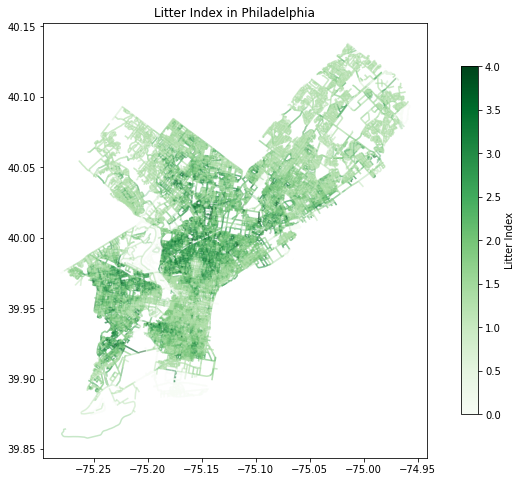

In [12]:
litter_plot = litter_gdf.plot(column='HUNDRED_BLOCK_SCORE', cmap='Greens', figsize=(12, 8), alpha=0.4, legend=True, legend_kwds = {
                        'shrink': 0.8,
                        'label': 'Litter Index'
                      })
plt.title('Litter Index in Philadelphia')
plt.show()

Observation
- The area with high litter index is mainly the central area of Philadelphia. It is also evident that the Western and Northern parts of Philadelphia have a relatively lower litter index score, indicating that these areas are cleaner. Southern tip of Philadelphia is also has relatively low litter index.

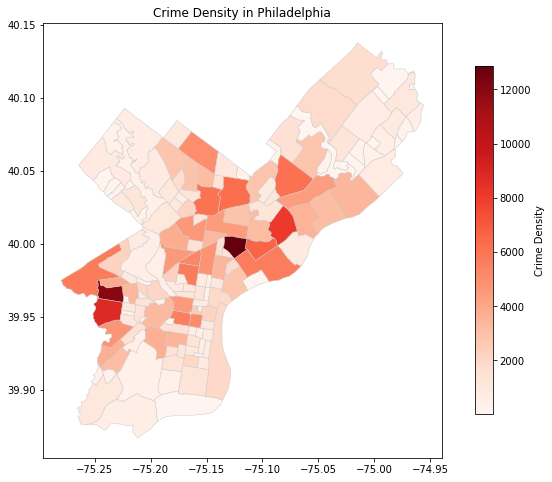

In [13]:
neighborhood_crime_gdf.plot(column='crime_count', cmap='Reds', linewidth=0.5, edgecolor='0.8', figsize=(12, 8), legend=True, 
                            legend_kwds = {
                                'shrink': 0.8,
                                'label': 'Crime Density'
                      })
plt.title('Crime Density in Philadelphia')
plt.show()

Observation
- The neighborhood with the highest crime density seems to be located in Central North and North Philadelphia as it is shaded in a dark red color on the map. Other areas with relatively high rates of crime incidents can be observed in neighborhoods in West Philadelphia.

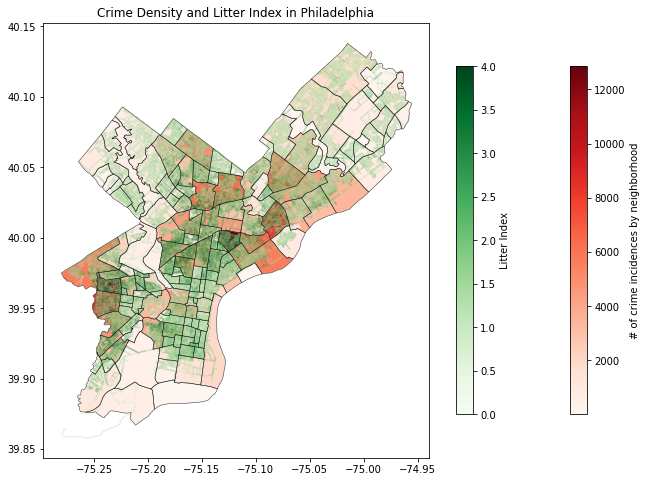

In [14]:
# Plotting the litter data with color scale legend
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plotting crime data
neighborhood_crime_gdf.plot(column='crime_count', cmap='Reds', linewidth=0.5, edgecolor='0.8', ax=ax, legend=True, legend_kwds = {
                        'shrink': 0.8,
                        'label': '# of crime incidences by neighborhood'
                      })

# Plotting litter data
litter_gdf.plot(column='HUNDRED_BLOCK_SCORE', cmap='Greens', alpha=0.2, legend=True, ax=ax, legend_kwds = {
                        'shrink': 0.8,
                        'label': 'Litter Index'
                      })

# Plotting neighborhood boundaries
neighborhood.boundary.plot(color='black', ax=ax, alpha=0.7, linewidth=0.5)

plt.title('Crime Density and Litter Index in Philadelphia')
plt.show()

Observation
- The litter index seems to be high when the area has a high number of crime incidents and relatively lower when the neighborhood has fewer crime incidents.

## Observing Types of Crimes

In [15]:
types_of_crimes = crime_df['text_general_code'].unique()
types_of_crimes

array(['Robbery No Firearm', 'Aggravated Assault Firearm',
       'Theft from Vehicle', 'Thefts', 'Robbery Firearm',
       'Aggravated Assault No Firearm', 'Burglary Residential',
       'Burglary Non-Residential', 'Rape',
       'Narcotic / Drug Law Violations', 'Other Assaults',
       'Vandalism/Criminal Mischief', 'All Other Offenses', 'Fraud',
       'DRIVING UNDER THE INFLUENCE',
       'Other Sex Offenses (Not Commercialized)', 'Weapon Violations',
       'Disorderly Conduct', 'Embezzlement', 'Forgery and Counterfeiting',
       'Arson', 'Public Drunkenness',
       'Prostitution and Commercialized Vice', 'Liquor Law Violations',
       'Offenses Against Family and Children', 'Gambling Violations',
       'Receiving Stolen Property', 'Vagrancy/Loitering',
       'Motor Vehicle Theft', 'Homicide - Criminal ',
       'Homicide - Criminal'], dtype=object)

In [16]:
violent_vals = ['Aggravated Assault Firearm', 'Aggravated Assault No Firearm', 'Robbery Firearm', 'Robbery No Firearm', 
                'Burglary Residential','Burglary Non-Residential', 'Rape', 'Arson', 'Theft from Vehicle', 'Thefts', 
                'Other Sex Offenses (Not Commercialized)', 'Motor Vehicle Theft', 'Homicide - Criminal ', 'Homicide - Criminal']

These violent crimes are categorized as "Part 1 crimes" from the website we got the data from.

In [17]:
non_violent_vals = ['Narcotic / Drug Law Violations', 'Other Assaults', 'Fraud', 'DRIVING UNDER THE INFLUENCE', 
                    'Weapon Violations', 'Disorderly Conduct', 'Embezzlement', 'Forgery and Counterfeiting','Public Drunkenness',
                    'Vandalism/Criminal Mischief', 'All Other Offenses', 'Prostitution and Commercialized Vice', 
                    'Liquor Law Violations', 'Offenses Against Family and Children',
                    'Gambling Violations','Receiving Stolen Property', 'Vagrancy/Loitering']

These non-violent crimes are categorized as "Part 2 crimes" from the website we got the data from.

## Plotting Litter Index and Violent Crime Density in Philadelphia by Neighborhood

In [18]:
# Group violent crimes
violent_df = crime_df[crime_df['text_general_code'].isin(violent_vals)]

In [19]:
# New GeoDataFrame for violent crimes
geometry_crime = [Point(xy) for xy in zip(violent_df['lng'], violent_df['lat'])]
crime_gdf = gpd.GeoDataFrame(violent_df, geometry=geometry_crime, crs='EPSG:4326')

In [20]:
if crime_gdf.crs != litter_gdf.crs:
    crime_gdf = crime_gdf.to_crs(litter_gdf.crs)

crime_by_neighborhood = gpd.sjoin(crime_gdf, neighborhood, how='left', op='within')
crime_counts = crime_by_neighborhood.groupby('index_right').size().reset_index(name='crime_count')
neighborhood_crime_gdf = neighborhood.merge(crime_counts, left_index=True, right_on='index_right', how='left')

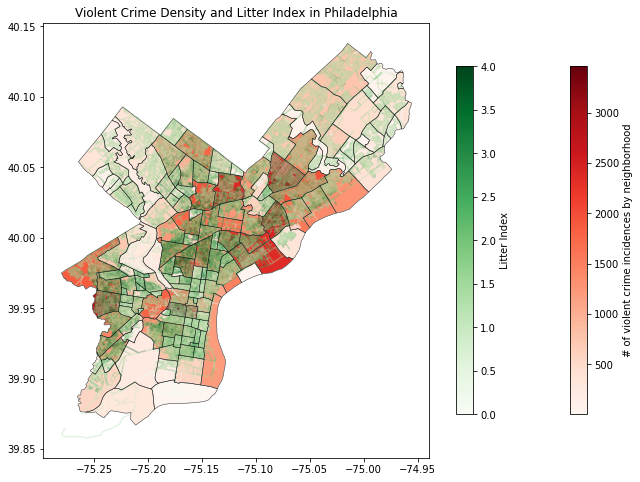

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
neighborhood_crime_gdf.plot(column='crime_count', cmap='Reds', linewidth=0.5, edgecolor='0.8', ax=ax, legend=True, legend_kwds = {
                        'shrink': 0.8,
                        'label': '# of violent crime incidences by neighborhood'
                      })
litter_gdf.plot(column='HUNDRED_BLOCK_SCORE', cmap='Greens', alpha=0.2, legend=True, ax=ax, legend_kwds = {
                        'shrink': 0.8,
                        'label': 'Litter Index'
                      })
neighborhood.boundary.plot(color='black', ax=ax, alpha=0.7, linewidth=0.5)
plt.title('Violent Crime Density and Litter Index in Philadelphia')
plt.show()

Observation
- As we can observe, some neighborhoods including Kensington, Frankford, and West Philadelphia have high numbers of violent crime incidents. Linking this to the litter index, it seems as though it is likely that a neighborhood with high numbers of violent crime incidents would have a higher litter index. Taking the instance of Kensington, the neighborhood has a particularly high rate of violent crimes and a relatively high litter index

## Plotting Litter Index and Non-Violent Crime Density in Philadelphia by Neighborhood

In [22]:
# Group non-violent crimes
non_violent_vals = crime_df[crime_df['text_general_code'].isin(non_violent_vals)]

In [23]:
# New GeoDataFrame for non-violent crimes
geometry_crime = [Point(xy) for xy in zip(non_violent_vals['lng'], non_violent_vals['lat'])]
crime_gdf = gpd.GeoDataFrame(non_violent_vals, geometry=geometry_crime, crs='EPSG:4326')

In [24]:
if crime_gdf.crs != litter_gdf.crs:
    crime_gdf = crime_gdf.to_crs(litter_gdf.crs)

crime_by_neighborhood = gpd.sjoin(crime_gdf, neighborhood, how='left', op='within')
crime_counts = crime_by_neighborhood.groupby('index_right').size().reset_index(name='crime_count')
neighborhood_crime_gdf = neighborhood.merge(crime_counts, left_index=True, right_on='index_right', how='left')

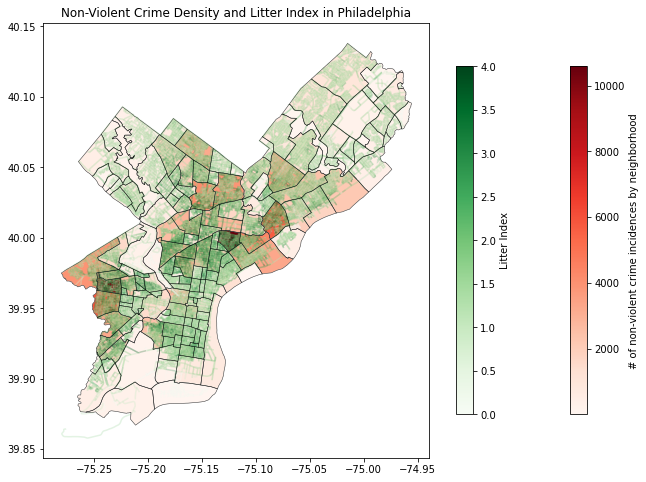

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
neighborhood_crime_gdf.plot(column='crime_count', cmap='Reds', linewidth=0.5, edgecolor='0.8', ax=ax, legend=True, legend_kwds = {
                        'shrink': 0.8,
                        'label': '# of non-violent crime incidences by neighborhood'
                      })
litter_gdf.plot(column='HUNDRED_BLOCK_SCORE', cmap='Greens', alpha=0.2, legend=True, ax=ax, legend_kwds = {
                        'shrink': 0.8,
                        'label': 'Litter Index'
                      })
neighborhood.boundary.plot(color='black', ax=ax, alpha=0.7, linewidth=0.5)
plt.title('Non-Violent Crime Density and Litter Index in Philadelphia')
plt.show()

Observation
- As we can observe, there are three main areas that seem to show very high numbers of non-violent crime incidents. There seems to be some correspondence between violent and non-violent crimes as most of the areas with high numbers of either of these crimes are either near Kensington and North Philadelphia or West Philadelphia. It is also evident that the three areas with high numbers of non-violent crime incidents also tend to have a higher litter index compared to areas with a lower number of non-violent crime incidents